In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(f'var{j+1}(t-{i})') for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [(f'var{j+1}(t+{i})') for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
file_path=r"D:\miniProject\review2\technical_indicators\BHP\DBP\BHPDBP.csv"
dataset = pd.read_csv(file_path,header=0,index_col=0)
values = dataset.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 7, 2)
print(reframed.head())
print("Reframed shape:", reframed.shape)

    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7    0.277301   0.310842   0.509504   0.467660   0.156915   0.290530   
8    0.535301   0.277301   0.310842   0.509504   0.248817   0.539708   
9    0.381652   0.535301   0.277301   0.310842   0.152056   0.414301   
10   0.475877   0.381652   0.535301   0.277301   0.000000   0.448283   
11   0.503781   0.475877   0.381652   0.535301   0.048435   0.463486   

    var7(t-7)  var8(t-7)  var9(t-7)  var10(t-7)  ...  var20(t+1)  var21(t+1)  \
7    0.306116   0.419790   0.565398    0.192608  ...    0.013714    0.738691   
8    0.458814   0.513149   0.590324    0.156915  ...    0.015006    0.694801   
9    0.556930   0.525917   0.564099    0.248817  ...    0.016675    0.547718   
10   0.490605   0.664739   0.611146    0.152056  ...    0.018211    0.621940   
11   0.569747   0.646821   0.750490    0.000000  ...    0.019624    0.571156   

    var22(t+1)  var23(t+1)  var24(t+1)  var25(t+1)  var26(t+1)  var27(t+1)  \
7     0.

In [4]:
values = reframed.values
train = values[:1079, :]
test = values[1080:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, test_X.shape)

(1079, 260) (221, 260)


In [5]:
def create_mlp_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    return model

model = create_mlp_model(train_X.shape[1])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,777 (171.00 KB)

 Trainable params: 43,777 (171.00 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = model.fit(
    train_X,
    train_y,
    validation_data=(test_X, test_y),
    epochs=400,
    batch_size=64,
    verbose=2
)

Epoch 1/400
17/17 - 2s - 106ms/step - loss: 0.0879 - mae: 0.2095 - val_loss: 0.0256 - val_mae: 0.1194
Epoch 2/400
17/17 - 0s - 10ms/step - loss: 0.0254 - mae: 0.1204 - val_loss: 0.0259 - val_mae: 0.1143
Epoch 3/400
17/17 - 0s - 9ms/step - loss: 0.0254 - mae: 0.1195 - val_loss: 0.0259 - val_mae: 0.1272
Epoch 4/400
17/17 - 0s - 9ms/step - loss: 0.0240 - mae: 0.1181 - val_loss: 0.0251 - val_mae: 0.1228
Epoch 5/400
17/17 - 0s - 9ms/step - loss: 0.0228 - mae: 0.1141 - val_loss: 0.0246 - val_mae: 0.1200
Epoch 6/400
17/17 - 0s - 8ms/step - loss: 0.0225 - mae: 0.1132 - val_loss: 0.0249 - val_mae: 0.1221
Epoch 7/400
17/17 - 0s - 8ms/step - loss: 0.0224 - mae: 0.1141 - val_loss: 0.0249 - val_mae: 0.1130
Epoch 8/400
17/17 - 0s - 8ms/step - loss: 0.0223 - mae: 0.1124 - val_loss: 0.0247 - val_mae: 0.1185
Epoch 9/400
17/17 - 0s - 8ms/step - loss: 0.0220 - mae: 0.1121 - val_loss: 0.0243 - val_mae: 0.1169
Epoch 10/400
17/17 - 0s - 8ms/step - loss: 0.0218 - mae: 0.1120 - val_loss: 0.0263 - val_mae: 0.1

In [ ]:
y_pred = model.predict(test_X)
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
mse = mean_squared_error(test_y, y_pred)
r2 = r2_score(test_y, y_pred)
print(f"RMSE: {rmse:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
RMSE: 0.1768, MSE: 0.0313, R²: 0.2388


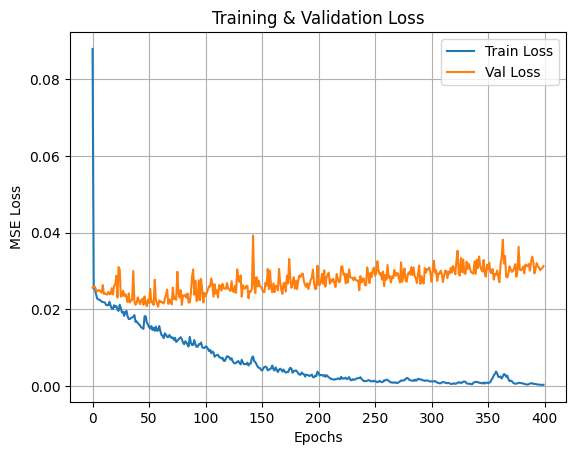

In [8]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()